## Import

This code is modified from a tutorial made by Stacey Shield: https://github.com/UCTMechatronics/pyomo_tutorials

Here we import all the required libraries to symbolically generate the EOM as well as print stuff to the screen
We also reset the console, getting rid of previous data

In [1]:
# %reset
# import libraries
import sympy as sym
import numpy as np
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

#sym.init_printing()
from IPython.display import display

In [2]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
m = ConcreteModel() # create model using pyomo
N = 35 # number of nodes (much like samples used between a certain time period)
hm=0.5/N # I think this is the time step
m.N = RangeSet(N) 
m.damping=20

mass_b=2 # Mass of the base
mass_l=1 # Mass of the links
len_b=0.3 # Length of the base
m.l_min=0.2 # Links min length
m.l_max=len_b # Links max length
m.F_max=160 # Maximum force that can be applied
m.t_max=12 # Maximum torque
m.w_max=44 # Max angular velocity (omega)
m.dl_max=3
m.distance=0.5

print('Done')

Done


## EoM generation
Here we create our symbolic variables for the EoM of the system.

The symbolic variables include the mass, length and inertia of each of the robot links
the generalized coordinates include: X, Z, th_body, th_leg and the leg length (a prismatic leg). Relative angles are used
The generalized coordinates also include the velocities and accelerations. 

q=Generalized coordinates
dq=velocity of the generalized coordinates
ddq=acceleration of the generalized coordinates

Forces are also defined. This robot has a hip torque, tau, and a prismatic force to lengthen and shorten the leg, F
F is the total force, it contains the actuator force as well as a rebound force (hard-stop)

There is also a vertical and horizontal GRF

In [3]:
# create symbolic variables
g = sym.symbols('g')
mb,ml = sym.symbols(['m_{body}','m_{leg}']) # mass
lb = sym.symbols(['l_{body}']) # length
Inb,Inl = sym.symbols(['I_{body}','I_{leg}']) # moment of intertia

# generalized coordinates
x,z,thb,thl,r = sym.symbols(['x','z','\\theta_{body}','\\theta_{leg}','r']) 
dx,dz,dthb,dthl,dr = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{body}','\dot{\\theta}_{leg}','\dot{r}']) 
ddx,ddz,ddthb,ddthl,ddr = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg}','\ddot{r}']) 

q = sym.Matrix([[x],[z],[thb],[thl],[r]])
dq = sym.Matrix([[dx],[dz],[dthb],[dthl],[dr]])
ddq = sym.Matrix([[ddx],[ddz],[ddthb],[ddthl],[ddr]])

# forces
F,tau,GRFx,GRFz = sym.symbols(['F','\\tau','G_x','G_z']) 
print('Done')

Done


The position of the COM of each link. [x,z] is the COM of the body. Assuming the CoM is half way, with uniform inertia
rb is the CoM of the body
rl is the CoM of the leg

the body is horizontal, so the leg attaches to the CoM of the body

In [4]:
# STEP 1: position vector (COM of each link), as well as other required positions. 
rb = sym.Matrix([[x],
                [z]])

rl = sym.Matrix([[x + (0.5*r)*sym.cos(thl)],
                 [z - (0.5*r)*sym.sin(thl)]])

footx = sym.Matrix([x + r*sym.cos(thl)])
footz = sym.Matrix([z - r*sym.sin(thl)]) 
footz = footz[0].simplify()
foot_pos= sym.Matrix([[footx],[0],[footz]])
print('Done')

Done


This leads to the following COM's ...
$$rb = \begin{pmatrix} x \\ z \end{pmatrix}$$
$$rl = \begin{pmatrix} x+(0.5*r)cos(\theta_l) \\ z-(0.5*r)sin(\theta_l) \end{pmatrix}$$
$$footx = \begin{pmatrix} x+r*cos(\theta_l) \end{pmatrix}$$
$$footz = \begin{pmatrix} z-r*sym.sin(\theta_l) \end{pmatrix}$$
$$foot_{pos} = \begin{pmatrix} footx \\ 0 \\ footz \end{pmatrix}$$

From the positions defined above, calculate the velocities

In [5]:
# STEP 2: generate expressions for the system space velocities from the jacobians
# the Jacobians
Jb = rb.jacobian(q)
Jl = rl.jacobian(q)

vb = Jb*dq
vl = Jl*dq

footdx = footx.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footdx = footdx[0].simplify()
print('Done')

Done


Using the positions and velocities, calculate the kinetic and potential energy. This is used to generate the EoM using 
Lagrange Dynamics

In [6]:
# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb]])
Ml = sym.Matrix([[ml,ml]])

Ib=sym.Matrix([[Inb]])
Il=sym.Matrix([[Inl]])

Wb=sym.Matrix([[dthb]])
Wl=sym.Matrix([[dthl]])

# linear kinetic energy:
T1 = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml*sym.matrix_multiply_elementwise(vl,vl)
# angular kinetic energy:
T2 =  0.5*Ib*sym.matrix_multiply_elementwise(Wb,Wb) + 0.5*Il*sym.matrix_multiply_elementwise(Wl,Wl) #this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([T1[0]])+sym.Matrix([T2[0]])
# potential energy
V = mb*g*rb[1] + ml*g*rl[1]
print('Done')

Done


The Matrix Mb was created to simplify the code in the following way:

0.5* Mb* sym.matrix_multiply_elementwise(vb,vb) 
$$ = \begin{pmatrix} 0.5 \dot{x}^2m_{body} + 0.5 \dot{z}^2m_{body} \end{pmatrix}$$

Using the normal *mb* will lead to...

0.5* mb* sym.matrix_multiply_elementwise(vb,vb)
$$ = \begin{pmatrix} 0.5 \dot{x}^2m_{body} \\ 0.5 \dot{z}^2m_{body} \end{pmatrix}$$
The x and z element needs to be added to it is just one step shorter

Calculate T (kinetic energy) using...
$$T = 0.5m \times \dot{x}^2$$
do this for linear and angular kinetic energy

Also calculate V (potential energy)...
$$V = mg \times height_{body}$$

In [7]:
print('T =')
display(T)
display('******************************************************************************************************')
print("V =")
display(V)

T =


Matrix([[0.5*I_{body}*\dot{\theta}_{body}**2 + 0.5*I_{leg}*\dot{\theta}_{leg}**2 + 0.5*\dot{x}**2*m_{body} + 0.5*\dot{z}**2*m_{body} + 0.5*m_{leg}*(-0.5*\dot{\theta}_{leg}*r*sin(\theta_{leg}) + 0.5*\dot{r}*cos(\theta_{leg}) + \dot{x})**2 + 0.5*m_{leg}*(-0.5*\dot{\theta}_{leg}*r*cos(\theta_{leg}) - 0.5*\dot{r}*sin(\theta_{leg}) + \dot{z})**2]])

'******************************************************************************************************'

V =


g*m_{body}*z + g*m_{leg}*(-0.5*r*sin(\theta_{leg}) + z)

*********************************************************************************************************************************************************************************************

Use the manipulator equation to calculate the EoM

EOM=M * ddq+C * dq+ G-Q-J.' * GRF;

In [8]:
M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

J=foot_pos.jacobian(q)
GRF_l = J.transpose()*sym.Matrix([[GRFx],[0],[GRFz]])   

Q = sym.zeros(len(q),1)
Q[0]=0                #X
Q[1]=0                #Z
Q[2]=-tau             #thb
Q[3]=tau              #thl
Q[4]=F-dr*m.damping   #r
           
EOM=M*ddq+C*dq+G-Q-GRF_l

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
print('Done')

Done


This is some weird maths that breaks my brain #theBigSad

The EOM needs to be found, it looks as follow
$$EOM=M(q)\ddot{q}+C(q,\dot{q})\dot{q}+G(q)-Q-GRF$$
Lets try to explain some things and see if it helps.

$M$ is the mass matrix. According the most trusted site (Wikipedia), the mass matrix is a symmetric matrix M that expresses the connection between the time derivative $\dot {q}$ of the generalized coordinate vector $q$ of a system and the kinetic energy $T$ of that system. It look something like this:
$$T = \frac{1}{2} \dot{q}^TM\dot{q}$$
So using the power of maths, it can be rearrangend to find $M$

$C$ is the Coriolis matrix. When it needs to be calculated then just copy the provided code ;)


*******************************************

## Lambdify
Here we need to lamdify the instructions. Basically linking symbolic lists to variables as well as function mapping..... It converts the symbolic representation to equations that the optimizer can use.....

In [9]:
# Lambdify


func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml,lb,Inb,Inl,
            x,z,thb,thl,r,
            dx,dz,dthb,dthl,dr,
            ddx,ddz,ddthb,ddthl,ddr,
            F,tau,GRFx,GRFz]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map]) # Should be the z-direction but fixing this will take effort
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thl = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_r = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

lamb_footz = sym.lambdify(sym_list,footz,modules = [func_map])
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])
print('Done')

Done


All the variables above are not linked to the model and was only used to get the EOM.

The variables for the model will now be in the code down below.

********
*********


## Trajectory optimization
Here we define all the variables for the trajectory optimization problem (do not confuse them with the variables we defined above for the EoM). All variables defined are linked to the model (m). 

N= node, how many time points the trajectory is split into
cN= collocation points, number of sub points per collocation point

q= generalized coordinates for the node points and collocation points
q0= generalized coordinates for the node points only

The time bounds are similarily split up as well

![Drag Racing](collocation.jpg)


In [10]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('body',1),('leg',1)]
m.L = Set(dimen=2, initialize=links)

DOFs = ['x','z','theta_b','theta_l','r'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N)


m.h = Var(m.N, bounds =(0.1,2.0))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


Here we define the parameters of the model
g=gravity
pi=pi

all the masses and inertia values (converting from symbol to numerical value)

In [11]:
# PARAMETERS-----------------------------------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81)
pi=sym.pi

m.mb = Param(initialize = mass_b)
m.ml = Param(initialize = mass_l)
m.lb = Param(initialize = len_b)

m.Inb= Param(initialize = m.mb.value*m.lb.value**2/12)   
m.Inl= Param(initialize = m.ml.value*m.lb.value**2/12)  ##############################m.ml.value*m.q[m.n,m.cN,'r']**2/12

mbody = mass_b+mass_l
BW = mbody*m.g.value

print('Done')

Done


#### Collocation constraints
Here we implement the collocation constraints (see image above as to how q0 and q are linked)

In [12]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)
def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)
def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)
print('Done')

Done


#### Integration: 3 point collocation, Runge Kutta integration 
Here we implement the integration

In [13]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)
def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)
def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)
print('Done')

Done


#### GRF stuff

Here we set up the + and - sign of the GRF. See: A direct method for trajectory optimization of rigid bodies through contact
https://journals.sagepub.com/doi/abs/10.1177/0278364913506757
OR
https://groups.csail.mit.edu/robotics-center/public_papers/Posa13.pdf
 
Look at equations 8 to 16. Eq 8 and 9 force positive variables. Eq 10, 11 and 12 are technically not needed. 
 
Eq 13 is handled as follows:
m.a_contact_1[n,c] == lamb_footz(*var_list)
m.b_contact_1[n,c] == m.GRF[n,c,'Z','ps']
a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
return a_contact_1_pr*b_contact_1_pr <= m.eps
 
Eq 14 is handled as follows:
m.a_friction_1[n,c] == m.mu*m.GRF[n,c,'Z','ps'] - (m.GRF[n,c,'X','ps'] + m.GRF[n,c,'X','ng'])
m.b_friction_1[n,c] == m.gamma_1[n,c]
a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
return a_friction_1_pr*b_friction_1_pr <= m.eps
 
Eq 15 is handled as follows:
m.a_slip_p_1[n,c] ==m.gamma_1[n,c]+lamb_footdx(*var_list)
m.b_slip_p_1[n,c] == m.GRF[n,c,'X','ps']
a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
 
Eq 16 is handled as follows: 
m.a_slip_n_1[n,c] ==m.gamma_1[n,c]-lamb_footdx(*var_list)
m.b_slip_n_1[n,c] == m.GRF[n,c,'X','ng']
a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps



In [14]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X', 'Z','THETA1']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
m.GRF = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


define all the slack variables

In [15]:
# SLACK VARIABLES
m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 
print('Done')

Done


Handle the contact event

In [16]:
# CONTACT
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.mb,m.ml,
            m.lb,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
            0,0,0,0]
        return m.a_contact_1[n,c] == lamb_footz(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)
def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)
print('Done')

Done


Handle the friction cone

In [17]:
# FRICTION CONE
def def_a_friction_1(m,n,c):   
    return m.a_friction_1[n,c] == m.mu*m.GRF[n,c,'Z','ps'] - (m.GRF[n,c,'X','ps'] + m.GRF[n,c,'X','ng'])
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)
def def_b_friction_1(m,n,c):   
    return m.b_friction_1[n,c] == m.gamma_1[n,c]
m.def_b_friction_1 = Constraint(m.N, m.cN, rule = def_b_friction_1)
print('Done')

Done


Handle the foot slipping (make sure it slips in the correct direction)

In [18]:
#SLIP POS DIR
def def_a_slip_p_1(m,n,c):   
    var_list = [m.g,m.mb,m.ml,
        m.lb,
        m.Inb,m.Inl,
        m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
        m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
        m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
        0,0,0,0]
    return m.a_slip_p_1[n,c] ==m.gamma_1[n,c]+lamb_footdx(*var_list)
m.def_a_slip_p_1 = Constraint(m.N, m.cN, rule = def_a_slip_p_1)
def def_b_slip_p_1(m,n,c):   
    return m.b_slip_p_1[n,c] == m.GRF[n,c,'X','ps']
m.def_b_slip_p_1 = Constraint(m.N, m.cN, rule = def_b_slip_p_1)

# SLIP NEG DIR
def def_a_slip_n_1(m,n,c):   
    var_list = [m.g,m.mb,m.ml,
        m.lb,
        m.Inb,m.Inl,
        m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
        m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
        m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
        0,0,0,0]
    return m.a_slip_n_1[n,c] ==m.gamma_1[n,c]-lamb_footdx(*var_list)
m.def_a_slip_n_1 = Constraint(m.N, m.cN, rule = def_a_slip_n_1)
def def_b_slip_n_1(m,n,c):   
    return m.b_slip_n_1[n,c] == m.GRF[n,c,'X','ng']
m.def_b_slip_n_1 = Constraint(m.N, m.cN, rule = def_b_slip_n_1)

print('Done')

Done


Sum the complimentarity parts across the collocation points and evaluate at the node points

In [19]:
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

def def_friction_1_pr(m,n):
    a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
    b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
    return a_friction_1_pr*b_friction_1_pr <= m.eps
m.def_friction_1_pr = Constraint(m.N, rule = def_friction_1_pr)

def def_slip_p_1_pr(m,n):
    a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
    b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
    return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
m.def_slip_p_1_pr = Constraint(m.N, rule = def_slip_p_1_pr)

def def_slip_n_1_pr(m,n):
    a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
    b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
    return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps
m.def_slip_n_1_pr = Constraint(m.N, rule = def_slip_n_1_pr)
print('Done')

Done


#### Motor model

Here we implement a motor model. In this example we implement it through bounds (see bounds section) and a liner motor model. See: Do Intermediate Gaits Matter When Rapidly Accelerating? https://static1.squarespace.com/static/542ddec8e4b0158794bd1036/t/5e3e0275c0b9914844da5cc0/1581122167965/Fisher_etal_2019.pdf eq(6)

In [20]:
m.tau_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip
m.F_a = Var(m.N, bounds = (-m.F_max,m.F_max)) # actuator prismatic force

def def_hip_motor_model_p(m,n):
    return  m.tau_a[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_l']-m.dq0[n,'theta_b'])
m.def_hip_motor_model_p = Constraint(m.N, rule = def_hip_motor_model_p)
def def_hip_motor_model_n(m,n):
    return  m.tau_a[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_l']-m.dq0[n,'theta_b'])
m.def_hip_motor_model_n = Constraint(m.N, rule = def_hip_motor_model_n)

print('Done')

Done


#### EoM constraints
Make sure the EoM are satisfied

In [21]:
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

S=1.0 #BW/m.mTot    #Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    F_in = S*(m.F_a[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
            F_in,tau_in,Gx_in,Gz_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    F_in = S*(m.F_a[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
            F_in,tau_in,Gx_in,Gz_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_thb(m,n,c):
    F_in = S*(m.F_a[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
            F_in,tau_in,Gx_in,Gz_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, m.cN, rule = EOM_thb)

def EOM_thl(m,n,c):
    F_in = S*(m.F_a[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
            F_in,tau_in,Gx_in,Gz_in]
    return lambEOM_thl(*var_list) == 0
m.EOM_thl = Constraint(m.N, m.cN, rule = EOM_thl)

def EOM_r(m,n,c):
    F_in = S*(m.F_a[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_b'],m.q[n,c,'theta_l'],m.q[n,c,'r'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_b'],m.dq[n,c,'theta_l'],m.dq[n,c,'r'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_b'],m.ddq[n,c,'theta_l'],m.ddq[n,c,'r'],
            F_in,tau_in,Gx_in,Gz_in]
    return lambEOM_r(*var_list) == 0
m.EOM_r = Constraint(m.N, m.cN, rule = EOM_r)
print('Done')

Done


#### Bounds
Bound all variables here. Bound to either enforce something (eg leg length) or bound sufficiently high to reduce the search space but not effect the solution. For example if robot runs from 0m to 5m, bound the x variable to -1m to 6m. This does not effect the solution space, but drastically reduces the search space (x was -inf to inf).

In [22]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 1.0)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setthbBounds(m,n):
    return (-3.14/2, m.q0[n,'theta_b'], 3.14/2)
m.setthbBounds = Constraint(m.N, rule=setthbBounds)
def setthlBounds(m,n):
    return (0, m.q0[n,'theta_l'], 3.14)
m.setthlBounds = Constraint(m.N, rule=setthlBounds)
def setrBounds(m,n):
    return (m.l_min, m.q0[n,'r'], m.l_max)
m.setrBounds = Constraint(m.N, rule=setrBounds)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setdthbBounds(m,n):
    return (-20, m.dq0[n,'theta_b'], 20)
m.setdthbBounds = Constraint(m.N, rule=setdthbBounds)
def setdthlBounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_l'], m.w_max)
m.setdthlBounds = Constraint(m.N, rule=setdthlBounds)
def setdrBounds(m,n):
    return (-m.dl_max, m.dq0[n,'r'],m.dl_max)
m.setdrBounds = Constraint(m.N, rule=setdrBounds)

print('Done')

Done


#### Seed generation
In order to search the solution space, a random seed point (start point) is generated. This means that occasionally you will not get a solution, and if you do, it may be a bad solution. In that case, generate a bunch of seeds or start the optimizer with a good seed point

In [23]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = Domain[n-1] + np.random.uniform(-0.25,0.25)    
        m.q[n,c,'z'].value  = Range[n-1] + np.random.uniform(-0.25,0.25)
        m.q[n,c,'theta_b'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'theta_l'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'r'].value  = np.random.uniform(0.0,0.5)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01


        m.GRF[n,c,'Z','ps'].value = 0.01
        m.GRF[n,c,'X','ps'].value = 0.01 
        m.GRF[n,c,'X','ng'].value = 0.01 
        
print('Done')

Done


#### End conditions
In order to enforce a steady-state step, a number of start and end conditions are implemented
generally start conditions are enforced through bounds and end conditions are enforced through constraints.

In [24]:
# constraints for steady-state 
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True

def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == m.q0[1,'z']
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)


def finalthb(m,n):
    if (n==N) :
        return m.q0[n,'theta_b'] == m.q0[1,'theta_b']
    else:
        return Constraint.Skip
m.finalthb = Constraint(m.N, rule = finalthb)


def finalthl(m,n):
    if (n==N) :
        return m.q0[n,'theta_l'] == m.q0[1,'theta_l']
    else:
        return Constraint.Skip
m.finalthl = Constraint(m.N, rule = finalthl)

def finalr(m,n):
    if (n==N) :
        return m.q0[n,'r'] == m.q0[1,'r']
    else:
        return Constraint.Skip
m.finalr = Constraint(m.N, rule = finalr)


def finaldx(m,n):
    if (n==N) :
        return m.dq0[n,'x'] == m.dq0[1,'x']
    else:
        return Constraint.Skip
m.finaldx = Constraint(m.N, rule = finaldx)

def finaldz(m,n):
    if (n==N) :
        return m.dq0[n,'z'] == m.dq0[1,'z']
    else:
        return Constraint.Skip
m.finaldz = Constraint(m.N, rule = finaldz)

def finaldthb(m,n):
    if (n==N) :
        return m.dq0[n,'theta_b'] == m.dq0[1,'theta_b']
    else:
        return Constraint.Skip
m.finaldthb = Constraint(m.N, rule = finaldthb)


def finaldthl(m,n):
    if (n==N) :
        return m.dq0[n,'theta_l'] == m.dq0[1,'theta_l']
    else:
        return Constraint.Skip
m.finaldthl = Constraint(m.N, rule = finaldthl)

def finaldr(m,n):
    if (n==N) :
        return m.dq0[n,'r'] == m.dq0[1,'r']
    else:
        return Constraint.Skip
m.finaldr = Constraint(m.N, rule = finaldr)
print('Done')

Done


#### Run the solver

First define the cost. We set the cost to 1, solve the seed, then set the cost to the correct value and re-solve in a loop. 
after each solve, reduce the epsilon value and solve again until within good tolerance

In [25]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum(((m.tau_a[n]**2+m.F_a[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.13.2: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    14831
Number of nonzeros in inequality constraint Jacobian.:     1401
Number of nonzeros in Lagrangian Hessian.............:     4619

Total number of variables............................:     3428
                     variables with only lower bounds:     1260
                variables with lower and upper bounds:      105
         

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0000000e+00 1.34e+01 8.39e+04  -1.0 1.82e+02   0.8 2.01e-02 5.26e-02f  1
  81  1.0000000e+00 1.32e+01 7.80e+04  -1.0 1.86e+02   1.2 2.03e-02 1.27e-02h  1
  82  1.0000000e+00 1.30e+01 7.63e+04  -1.0 2.03e+02   0.7 7.41e-03 2.12e-02f  1
  83  1.0000000e+00 1.30e+01 7.48e+04  -1.0 1.87e+02   1.1 1.44e-02 4.78e-04h  1
  84  1.0000000e+00 1.29e+01 7.45e+04  -1.0 1.91e+02   0.7 2.02e-03 3.18e-03h  1
  85  1.0000000e+00 1.28e+01 7.41e+04  -1.0 2.68e+02   0.2 1.93e-02 1.26e-02f  1
  86  1.0000000e+00 1.28e+01 7.39e+04  -1.0 1.92e+02   0.6 6.91e-03 1.15e-04h  1
  87  1.0000000e+00 1.24e+01 7.17e+04  -1.0 3.08e+02   0.1 5.13e-03 2.67e-02f  1
  88  1.0000000e+00 1.08e+01 2.54e+05  -1.0 1.94e+02   0.5 6.90e-04 1.44e-01f  1
  89  1.0000000e+00 1.06e+01 1.59e+05  -1.0 4.75e+02   0.1 5.93e-02 1.06e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0000000e+00 1.01e+01

Number of inequality constraint evaluations          = 181
Number of equality constraint Jacobian evaluations   = 176
Number of inequality constraint Jacobian evaluations = 176
Number of Lagrangian Hessian evaluations             = 174
Total CPU secs in IPOPT (w/o function evaluations)   =     24.466
Total CPU secs in NLP function evaluations           =      1.759

EXIT: Optimal Solution Found.
    'pyomo.core.base.objective.SimpleObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.SimpleObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
1000.0
Ipopt 3.13.2: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EP

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  6.6276217e+03 9.68e-02 4.29e+00  -2.5 3.80e+01  -2.6 1.00e+00 1.00e+00f  1
  71  6.4827505e+03 2.73e-01 4.42e+01  -2.5 2.52e+02  -3.0 1.32e-01 1.57e-01f  1
  72  6.4671375e+03 2.60e-01 4.96e+02  -2.5 6.31e+01  -2.6 1.00e+00 5.03e-02f  1
  73  6.2780361e+03 5.13e-01 6.62e+02  -2.5 4.36e+02  -3.1 1.55e-01 9.23e-02f  1
  74  6.2743165e+03 5.09e-01 8.81e+02  -2.5 8.53e+01  -2.7 1.00e+00 6.86e-03f  1
  75  6.2124384e+03 5.41e-01 1.20e+03  -2.5 4.01e+03  -3.1 2.59e-02 5.66e-03f  1
  76  6.2014772e+03 5.32e-01 1.40e+03  -2.5 1.04e+02  -2.7 1.00e+00 1.65e-02f  1
  77  5.9908256e+03 1.46e-01 9.09e+01  -2.5 3.22e+01  -2.3 1.00e+00 8.80e-01f  1
  78  5.8746788e+03 1.59e-01 7.92e+02  -2.5 1.88e+02  -2.8 5.09e-01 1.25e-01f  1
  79  5.8666001e+03 1.55e-01 6.92e+02  -2.5 4.44e+01  -2.3 1.00e+00 2.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  5.6124086e+03 3.32e-01

 163  3.1506035e+03 7.51e-01 3.67e+02  -2.5 1.21e+02  -2.7 8.99e-04 4.44e-04h  1
 164  3.1497003e+03 7.42e-01 5.74e+02  -2.5 5.61e+01  -3.2 5.40e-01 1.18e-02f  1
 165  3.1317913e+03 6.39e-01 4.79e+02  -2.5 3.33e+02  -3.6 2.83e-02 1.37e-01f  1
 166  3.1267023e+03 5.87e-01 5.59e+02  -2.5 4.99e+01  -3.2 5.09e-01 8.07e-02h  1
 167  3.1102373e+03 4.88e-01 5.17e+02  -2.5 1.20e+02  -3.7 4.01e-03 1.60e-01f  1
 168  3.0998522e+03 3.95e-01 4.11e+02  -2.5 4.65e+01  -3.3 2.35e-01 1.88e-01f  1
 169  3.0934253e+03 3.67e-01 1.91e+02  -2.5 1.70e+02  -3.7 5.78e-01 6.83e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  3.0708482e+03 1.86e-01 1.27e+02  -2.5 4.86e+01  -3.3 1.07e-01 4.71e-01f  1
 171  3.0683280e+03 1.81e-01 1.48e+02  -2.5 1.93e+02  -3.8 1.00e+00 2.85e-02h  1
 172  3.0578338e+03 1.97e-01 9.89e+01  -2.5 3.46e+02  -4.3 2.14e-01 8.08e-02f  1
 173  3.0400804e+03 1.83e-01 3.14e+02  -2.5 1.12e+02  -3.8 1.00e+00 3.32e-01f  1
 174  3.0241556e+03 2.33e-01

 259  2.8907371e+03 1.71e-04 8.56e-04  -3.8 2.66e+01  -6.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  2.8907308e+03 5.43e-04 4.76e-01  -3.8 5.27e+01  -6.5 9.28e-01 1.00e+00h  1
 261  2.8907267e+03 5.82e+01 1.80e-03  -3.8 3.79e+01  -6.1 1.00e+00 1.00e+00h  1
 262  2.8907207e+03 5.62e-04 3.46e-03  -3.8 5.35e+01  -6.6 1.00e+00 1.00e+00h  1
 263  2.8906960e+03 6.92e-03 6.30e+00  -3.8 2.87e+02  -7.0 6.93e-01 9.63e-01h  1
 264  2.8906868e+03 4.21e-03 6.85e+00  -3.8 6.23e+02  -7.5 1.00e+00 4.16e-01h  1
 265  2.8906282e+03 3.47e-02 4.48e+00  -3.8 1.60e+03  -8.0 3.74e-01 1.00e+00h  1
 266  2.8905828e+03 4.26e-02 2.24e+01  -3.8 3.90e+03  -8.5 8.70e-01 3.37e-01h  1
 267  2.8904752e+03 3.33e-01 8.05e+00  -3.8 3.14e+03  -8.9 8.76e-01 1.00e+00h  1
 268  2.8905045e+03 3.65e-02 1.56e+00  -3.8 7.41e+02  -8.5 1.00e+00 9.26e-01h  1
 269  2.8905046e+03 2.26e-02 5.49e-01  -3.8 5.03e+02  -9.0 3.28e-01 4.22e-01h  2
iter    objective    inf_pr 

 355  2.8903381e+03 1.05e-09 2.75e-09  -5.7 5.75e+00  -9.4 1.00e+00 1.00e+00h  1
 356  2.8903381e+03 1.48e-10 2.09e-09  -5.7 2.15e+00  -9.0 1.00e+00 1.00e+00h  1
 357  2.8903381e+03 1.34e-09 1.30e-07  -5.7 6.76e+00  -9.5 1.00e+00 1.00e+00h  1
 358  2.8903381e+03 1.23e-08 2.41e-08  -5.7 1.89e+01 -10.0 1.00e+00 1.00e+00h  1
 359  2.8903381e+03 1.20e-07 7.96e-09  -5.7 5.03e+01 -10.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  2.8903381e+03 1.74e-08 1.88e-09  -5.7 1.96e+01 -10.0 1.00e+00 1.00e+00h  1
 361  2.8903381e+03 2.48e-09 1.88e-09  -5.7 7.29e+00  -9.6 1.00e+00 1.00e+00h  1
 362  2.8903381e+03 3.50e-10 1.86e-09  -5.7 2.73e+00  -9.2 1.00e+00 1.00e+00h  1
 363  2.8903381e+03 3.19e-09 1.85e-09  -5.7 8.09e+00  -9.6 1.00e+00 1.00e+00h  1
 364  2.8903381e+03 4.51e-10 1.84e-09  -5.7 3.03e+00  -9.2 1.00e+00 1.00e+00h  1
 365  2.8903381e+03 4.12e-09 1.83e-09  -5.7 9.01e+00  -9.7 1.00e+00 1.00e+00h  1
 366  2.8903381e+03 3.86e-08

 449  2.8903381e+03 4.11e-09 5.65e-10  -5.7 2.52e+00  -9.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  2.8903381e+03 3.67e-08 6.55e-10  -5.7 7.55e+00 -10.1 1.00e+00 1.00e+00h  1
 451  2.8903381e+03 5.14e-09 5.62e-10  -5.7 2.83e+00  -9.7 1.00e+00 1.00e+00h  1
 452  2.8903381e+03 4.59e-08 8.40e-10  -5.7 8.45e+00 -10.2 1.00e+00 1.00e+00h  1
 453  2.8903381e+03 6.44e-09 5.60e-10  -5.7 3.17e+00  -9.8 1.00e+00 1.00e+00h  1
 454  2.8903381e+03 5.74e-08 7.63e-09  -5.7 9.46e+00 -10.2 1.00e+00 1.00e+00h  1
 455  2.8903381e+03 8.04e-09 5.57e-10  -5.7 3.54e+00  -9.8 1.00e+00 1.00e+00h  1
 456  2.8903381e+03 7.16e-08 6.08e-10  -5.7 1.06e+01 -10.3 1.00e+00 1.00e+00h  1
 457  2.8903381e+03 1.57e-10 5.54e-10  -5.7 4.96e-01  -9.0 1.00e+00 1.00e+00h  1
 458  2.8903381e+03 1.41e-09 5.54e-10  -5.7 1.49e+00  -9.4 1.00e+00 1.00e+00h  1
 459  2.8903381e+03 1.27e-08 8.84e-10  -5.7 4.45e+00  -9.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 543  2.8903381e+03 6.98e-09 4.59e-08  -5.7 3.83e+00  -9.9 1.00e+00 1.00e+00h  1
 544  2.8903381e+03 6.19e-08 9.03e-09  -5.7 1.15e+01 -10.4 1.00e+00 1.00e+00h  1
 545  2.8903381e+03 8.65e-09 1.14e-08  -5.7 4.29e+00 -10.0 1.00e+00 1.00e+00h  1
 546  2.8903381e+03 1.21e-09 4.57e-10  -5.7 1.61e+00  -9.6 1.00e+00 1.00e+00h  1
 547  2.8903381e+03 1.09e-08 5.82e-09  -5.7 4.82e+00 -10.0 1.00e+00 1.00e+00h  1
 548  2.8903381e+03 9.59e-08 1.03e-09  -5.7 1.44e+01 -10.5 1.00e+00 1.00e+00h  1
 549  2.8903381e+03 8.17e-07 8.60e-09  -5.7 4.27e+01 -11.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  2.8903381e+03 1.12e-07 1.14e-09  -5.7 1.59e+01 -10.6 1.00e+00 1.00e+00h  1
 551  2.8903381e+03 1.57e-08 4.47e-10  -5.7 5.96e+00 -10.1 1.00e+00 1.00e+00h  1
 552  2.8903381e+03 2.20e-09 1.19e-07  -5.7 2.02e+01  -9.7 1.00e+00 1.00e+00h  1
 553  2.8903381e+03 1.96e-08 4.46e-10  -5.7 6.69e+00 -10.2 1.00e+00 1.00e+00h  1
 554  2.8903381e+03 1.72e-07

  49  3.4386962e+03 3.34e+02 6.21e+03  -1.0 1.22e+04  -8.2 2.16e-02 1.17e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.5209841e+03 3.07e+02 9.60e+03  -1.0 2.47e+04  -8.6 9.88e-03 7.56e-02h  1
  51  3.5321428e+03 3.01e+02 6.32e+03  -1.0 2.14e+04  -9.1 7.67e-02 1.75e-02h  1
  52  3.5475707e+03 2.87e+02 6.63e+03  -1.0 2.19e+03  -9.6 3.47e-03 4.31e-02h  1
  53  3.5622282e+03 2.74e+02 6.12e+03  -1.0 2.05e+03 -10.1 9.24e-02 4.28e-02h  1
  54  3.5829177e+03 2.60e+02 5.95e+03  -1.0 4.89e+03 -10.6 6.01e-03 5.04e-02h  1
  55  3.5844458e+03 2.59e+02 5.57e+03  -1.0 3.60e+03 -11.0 1.13e-01 3.80e-03h  1
  56  3.6273095e+03 2.33e+02 5.32e+03  -1.0 1.07e+04 -11.5 1.48e-02 9.29e-02h  1
  57  3.6823022e+03 2.06e+02 4.83e+03  -1.0 1.20e+04 -12.0 2.93e-02 1.11e-01h  1
  58  3.7582949e+03 1.78e+02 4.43e+03  -1.0 1.12e+04 -12.5 2.53e-02 1.25e-01h  1
  59  3.7877111e+03 1.72e+02 4.28e+03  -1.0 1.91e+04 -12.9 3.66e-02 3.34e-02h  1
iter    objective    inf_pr 

 143  3.7026794e+03 3.39e-02 6.39e+01  -2.5 4.16e+02  -6.2 8.26e-01 3.26e-01h  1
 144  3.7022336e+03 1.45e-02 2.38e-01  -2.5 1.51e+02  -5.8 9.91e-01 1.00e+00h  1
 145  3.7020020e+03 3.39e-02 2.58e+00  -2.5 4.40e+02  -6.2 4.98e-01 3.98e-01h  1
 146  3.7019693e+03 2.32e-02 6.48e+00  -2.5 5.48e+01  -4.9 1.00e+00 3.21e-01h  1
 147  3.7018823e+03 3.05e-03 3.61e+00  -2.5 5.89e+01  -5.4 3.69e-01 1.00e+00h  1
 148  3.7017585e+03 1.11e-02 1.37e+00  -2.5 1.48e+02  -5.9 1.00e+00 8.36e-01h  1
 149  3.7015918e+03 3.28e-02 2.56e-01  -2.5 3.30e+02  -6.3 8.08e-01 7.99e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  3.7014686e+03 3.83e-02 8.96e-01  -2.5 1.45e+03  -6.8 6.72e-02 1.06e-01h  1
 151  3.7013656e+03 2.91e-02 1.10e+00  -2.5 1.77e+02  -5.5 2.35e-01 2.55e-01h  1
 152  3.7011259e+03 2.33e-02 8.35e+00  -2.5 2.65e+02  -6.0 1.59e-01 4.24e-01h  1
 153  3.7010584e+03 2.44e-02 5.77e+00  -2.5 4.58e+03  -6.4 1.32e-02 8.06e-03h  1
 154  3.7008615e+03 3.69e-02

 237  3.6975774e+03 8.46e-04 3.78e+00  -7.0 1.91e+03  -5.9 8.28e-05 1.03e-02h  1
 238  3.6975713e+03 8.48e-04 6.02e+00  -7.0 5.19e+02  -6.4 4.59e-02 2.81e-03h  1
 239  3.6971816e+03 1.65e-02 2.65e+01  -7.0 5.24e+02  -6.8 1.13e-02 1.74e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  3.6966247e+03 1.30e+01 7.92e+01  -7.0 8.06e+01  -4.6 3.52e-02 1.00e+00f  1
 241  3.6966199e+03 1.28e+01 5.05e+01  -7.0 8.41e+01  -5.1 3.29e-01 1.69e-02h  1
 242  3.6966058e+03 1.25e+01 5.08e+01  -7.0 1.54e+02  -5.6 3.65e-03 2.56e-02f  1
 243  3.6962742e+03 4.98e+00 4.73e+01  -7.0 2.29e+02  -6.0 1.22e-03 3.89e-01f  1
 244  3.6960005e+03 4.54e+00 4.64e+01  -7.0 1.99e+03  -6.5 8.00e-03 4.39e-02f  1
 245  3.6959861e+03 4.53e+00 4.48e+01  -7.0 1.04e+04  -7.0 1.67e-03 7.28e-04f  1
 246  3.6959798e+03 4.53e+00 3.19e+01  -7.0 2.38e+03  -6.6 2.45e-02 8.60e-04f  1
 247  3.6959345e+03 4.53e+00 3.57e+01  -7.0 3.66e+04  -7.0 2.30e-03 5.19e-04f  1
 248  3.6959133e+03 4.51e+00

  18  3.7384514e+03 7.03e+02 1.55e+03  -1.0 1.86e+03 -12.1 6.32e-03 1.96e-01h  1
  19  3.7435226e+03 6.92e+02 9.86e+02  -1.0 1.45e+03 -12.6 8.53e-02 1.58e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.7506431e+03 6.76e+02 6.58e+02  -1.0 1.41e+03 -13.1 9.66e-02 2.19e-02h  1
  21  3.8416074e+03 5.05e+02 1.02e+03  -1.0 1.40e+03 -13.5 1.33e-01 2.40e-01h  1
  22  3.8519776e+03 4.88e+02 1.03e+03  -1.0 1.15e+03 -14.0 4.19e-02 3.28e-02h  1
  23  3.8752700e+03 4.47e+02 3.40e+03  -1.0 1.16e+03 -14.5 1.37e-01 7.88e-02h  1
  24  3.9603434e+03 3.24e+02 6.09e+03  -1.0 1.03e+03 -15.0 2.92e-02 2.66e-01h  1
  25  4.0027586e+03 2.80e+02 5.16e+03  -1.0 7.26e+02 -15.5 1.40e-01 1.33e-01h  1
  26  4.0612064e+03 2.39e+02 5.55e+03  -1.0 1.05e+03 -15.9 9.52e-02 1.45e-01h  1
  27  4.0662912e+03 2.37e+02 3.82e+03  -1.0 1.04e+03 -16.4 7.72e-02 9.90e-03h  1
  28  4.1343188e+03 2.13e+02 5.13e+03  -1.0 1.20e+03 -16.9 1.35e-03 9.83e-02h  1
  29  4.1365950e+03 2.12e+02

 115  5.7524563e+03 9.64e-01 8.96e+03  -3.8 1.46e+04  -7.5 1.34e-03 1.89e-02f  1
 116  5.7524554e+03 9.64e-01 8.96e+03  -3.8 1.59e+03  -8.0 1.80e-03 1.56e-04h  1
 117  5.7503687e+03 9.49e-01 8.89e+03  -3.8 9.63e+04  -8.5 3.69e-04 7.50e-03f  1
 118  5.7503732e+03 9.38e-01 8.80e+03  -3.8 1.14e+03  -8.0 1.32e-01 1.08e-02h  1
 119  5.7502958e+03 8.60e-01 8.06e+03  -3.8 1.31e+03  -8.5 4.10e-01 8.35e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  5.7500223e+03 3.91e-01 3.71e+03  -3.8 2.89e+02  -8.1 8.09e-03 5.44e-01h  1
 121  5.7496248e+03 2.77e-01 4.49e+03  -3.8 4.78e+03  -8.6 3.34e-02 2.31e-01h  1
 122  5.7495984e+03 2.70e-01 4.41e+03  -3.8 1.14e+03  -7.2 1.97e-02 2.46e-02h  1
 123  5.7495819e+03 2.31e-01 3.78e+03  -3.8 1.15e+03  -6.8 7.98e-02 1.43e-01f  1
 124  5.7495696e+03 2.29e-01 3.74e+03  -3.8 7.50e+02  -6.4 2.94e-02 9.55e-03h  1
 125  5.7495384e+03 2.20e-01 3.59e+03  -3.8 2.91e+02  -6.0 1.21e-01 4.10e-02f  1
 126  5.7494841e+03 2.03e-01

 212  5.7102983e+03 1.69e-02 2.47e+04  -5.7 1.91e+00   1.3 1.21e-03 2.60e-03h  1
 213  5.7102974e+03 1.68e-02 2.46e+04  -5.7 7.20e-01   1.7 1.94e-03 5.07e-03f  1
 214  5.7102974e+03 1.68e-02 2.46e+04  -5.7 2.21e+00   1.2 6.49e-03 1.02e-05h  4
 215  5.7102962e+03 1.67e-02 2.44e+04  -5.7 7.16e-01   1.7 1.02e-03 7.57e-03h  1
 216  5.7102962e+03 1.67e-02 2.44e+04  -5.7 2.25e+00   1.2 4.80e-03 3.93e-05h  4
 217  5.7102946e+03 1.64e-02 2.41e+04  -5.7 6.99e-01   1.6 1.12e-03 1.35e-02h  1
 218  5.7102930e+03 1.63e-02 2.39e+04  -5.7 6.51e-01   1.1 8.46e-03 6.43e-03f  1
 219  5.7102927e+03 1.63e-02 2.39e+04  -5.7 3.51e+00   0.7 1.32e-03 1.57e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  5.7102875e+03 1.63e-02 2.39e+04  -5.7 3.90e+00   0.2 3.11e-03 2.01e-03f  1
 221  5.7102754e+03 1.62e-02 2.38e+04  -5.7 4.10e+00  -0.3 3.96e-03 4.31e-03f  1
 222  5.7102679e+03 1.62e-02 2.37e+04  -5.7 4.27e+00  -0.8 3.38e-02 2.80e-03f  1
 223  5.7101332e+03 1.53e-02

 309  5.5670343e+03 6.23e-03 1.02e+03  -5.7 1.04e+02  -4.4 5.50e-01 2.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  5.5669311e+03 6.16e-03 1.07e+03  -5.7 3.07e+02  -4.8 3.12e-01 1.21e-02f  1
 311  5.5661801e+03 5.25e-03 9.04e+02  -5.7 1.12e+02  -4.4 7.28e-02 1.50e-01f  1
 312  5.5650875e+03 4.19e-03 7.07e+02  -5.7 3.91e+02  -4.9 3.15e-02 2.06e-01f  1
 313  5.5650261e+03 4.10e-03 7.12e+02  -5.7 1.23e+02  -4.5 4.12e-01 2.16e-02f  1
 314  5.5649522e+03 4.05e-03 7.08e+02  -5.7 5.54e+02  -4.9 1.94e-01 1.23e-02f  1
 315  5.5637904e+03 2.32e-03 4.02e+02  -5.7 1.38e+02  -4.5 3.29e-01 4.29e-01f  1
 316  5.5634634e+03 2.19e-03 3.78e+02  -5.7 5.86e+02  -5.0 2.94e-01 5.70e-02f  1
 317  5.5632581e+03 1.90e-03 3.29e+02  -5.7 1.10e+02  -4.6 3.11e-01 1.30e-01f  1
 318  5.5632372e+03 1.90e-03 3.24e+02  -5.7 6.85e+02  -5.0 1.15e-01 3.61e-03f  1
 319  5.5632371e+03 1.90e-03 3.34e+02  -5.7 1.74e+01  -3.7 2.66e-01 7.82e-05h  1
iter    objective    inf_pr 

 409  5.4157058e+03 4.38e-04 2.53e-04  -5.7 1.88e+01  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  5.4157055e+03 8.42e-04 3.25e-03  -5.7 6.58e+01  -8.3 1.00e+00 1.00e+00h  1
 411  5.4157036e+03 1.07e-03 1.68e-01  -5.7 4.34e+02  -8.8 1.00e+00 1.00e+00h  1
 412  5.4157001e+03 3.38e-06 4.26e-02  -5.7 5.76e+01  -7.4 1.00e+00 1.00e+00h  1
 413  5.4156980e+03 4.44e-07 1.79e-02  -5.7 3.95e+01  -7.0 1.00e+00 1.00e+00h  1
 414  5.4156966e+03 5.95e-08 5.70e-03  -5.7 1.95e+01  -6.6 1.00e+00 1.00e+00h  1
 415  5.4156908e+03 1.88e-07 3.15e-01  -5.7 1.62e+02  -7.1 1.00e+00 5.75e-01h  1
 416  5.4156862e+03 1.62e-07 3.50e+00  -5.7 2.22e+02  -6.6 1.00e+00 1.50e-01h  1
 417  5.4156727e+03 1.21e-07 5.90e-02  -5.7 6.54e+01  -6.2 1.00e+00 1.00e+00h  1
 418  5.4156639e+03 1.25e-07 8.54e+00  -5.7 6.46e+01  -5.8 1.00e+00 3.91e-01h  1
 419  5.4156520e+03 1.25e-07 5.95e+00  -5.7 2.86e+01  -5.4 1.00e+00 7.41e-01h  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.1314146e+03 5.88e+02 6.90e+03  -1.0 2.30e+03 -10.3 2.92e-02 3.66e-04h  1
  41  7.1567796e+03 5.85e+02 1.53e+04  -1.0 6.33e+03 -10.8 1.53e-03 4.68e-03h  1
  42  7.2430236e+03 5.75e+02 4.90e+04  -1.0 6.32e+03 -11.2 4.79e-03 1.54e-02h  1
  43  7.2883548e+03 5.71e+02 3.60e+04  -1.0 7.33e+03 -11.7 1.12e-02 7.66e-03h  1
  44  7.4548815e+03 5.54e+02 6.62e+04  -1.0 3.20e+03 -12.2 3.23e-04 2.88e-02h  1
  45  7.7207488e+03 5.26e+02 7.87e+04  -1.0 2.82e+03 -12.7 1.09e-01 4.82e-02h  1
  46  8.2258891e+03 4.77e+02 5.59e+04  -1.0 2.87e+03 -13.1 1.14e-02 9.15e-02h  1
  47  8.2722356e+03 4.72e+02 7.31e+04  -1.0 2.94e+03 -13.6 1.07e-01 9.47e-03h  1
  48  8.2772742e+03 4.71e+02 6.57e+04  -1.0 6.40e+03 -14.1 6.07e-02 9.04e-04h  1
  49  8.4080766e+03 4.61e+02 1.36e+05  -1.0 7.49e+03 -14.6 9.63e-02 2.25e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  9.0199111e+03 4.15e+02

 139  1.8193553e+04 1.30e+02 9.52e+05  -1.0 6.80e+02  -2.2 2.31e-02 6.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.8251445e+04 1.29e+02 9.57e+05  -1.0 9.85e+02  -2.6 4.47e-02 1.49e-02h  1
 141  1.8419011e+04 1.24e+02 7.74e+05  -1.0 5.07e+02  -2.2 4.28e-04 3.72e-02h  1
 142  1.8420825e+04 1.24e+02 7.89e+05  -1.0 4.73e+03  -2.7 8.40e-04 1.29e-03h  1
 143  1.8450560e+04 1.22e+02 7.14e+05  -1.0 5.16e+02  -2.3 3.06e-02 1.37e-02h  1
 144  1.8465952e+04 1.21e+02 1.06e+06  -1.0 4.69e+02  -1.8 4.97e-02 4.42e-03h  1
 145  1.8467484e+04 1.21e+02 1.19e+06  -1.0 1.67e+03  -2.3 1.92e-02 3.92e-03h  1
 146  1.8616118e+04 1.15e+02 6.65e+05  -1.0 4.40e+02  -1.9 8.90e-04 4.85e-02h  1
 147  1.8631030e+04 1.13e+02 6.62e+05  -1.0 6.36e+02  -2.4 1.20e-02 1.25e-02h  1
 148  1.8689412e+04 1.11e+02 6.49e+05  -1.0 3.92e+02  -2.0 2.39e-02 2.30e-02h  1
 149  1.8690473e+04 1.10e+02 5.70e+05  -1.0 1.15e+03  -2.4 7.92e-03 3.58e-03h  1
iter    objective    inf_pr 

 235  1.6167753e+04 3.19e-02 5.21e+03  -1.0 1.14e+02  -3.7 4.67e-01 7.00e-01f  1
 236  1.6145239e+04 5.26e-02 2.97e+03  -1.0 3.58e+02  -4.2 4.70e-01 4.33e-01f  1
 237  1.6141567e+04 2.34e-03 1.46e+03  -1.0 1.44e+01  -2.9 7.94e-01 9.61e-01f  1
 238  1.6138031e+04 6.50e-03 1.64e+03  -1.0 3.75e+01  -3.4 1.00e+00 4.37e-01f  1
 239  1.6124678e+04 1.78e-02 1.55e+03  -1.0 1.26e+02  -3.8 9.99e-01 7.74e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  1.6118349e+04 1.85e-02 8.38e+03  -1.0 3.43e+02  -4.3 3.71e-01 2.20e-01f  1
 241  1.6114693e+04 1.24e-02 1.42e+04  -1.0 1.14e+02  -3.9 5.88e-01 4.60e-01f  1
 242  1.6110915e+04 1.91e-03 4.13e+00  -1.0 4.46e+01  -3.5 1.00e+00 1.00e+00f  1
 243  1.6105440e+04 7.62e-03 1.18e+02  -2.5 8.34e+02  -3.9 7.83e-02 7.63e-02f  1
 244  1.6102476e+04 7.15e-03 7.16e+03  -2.5 2.09e+02  -3.5 2.43e-01 6.46e-02f  1
 245  1.6096997e+04 6.06e-03 5.85e+03  -2.5 3.08e+01  -3.1 1.45e-01 1.53e-01f  1
 246  1.6086684e+04 2.53e-03

 335  1.5906557e+04 1.58e-03 2.05e+03  -2.5 8.16e+01  -4.5 1.55e-01 4.95e-01f  1
 336  1.5906364e+04 1.51e-03 1.12e+03  -2.5 2.89e+02  -5.0 6.46e-01 5.33e-02f  1
 337  1.5906024e+04 1.57e-03 8.97e+02  -2.5 4.44e+02  -5.4 1.04e-01 6.57e-02f  1
 338  1.5905717e+04 2.12e-03 2.80e+03  -2.5 1.14e+03  -5.9 2.68e-01 7.47e-02f  1
 339  1.5905623e+04 2.10e-03 2.78e+03  -2.5 2.32e+03  -6.4 2.41e-02 2.26e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  1.5905477e+04 2.06e-03 1.23e+04  -2.5 2.18e+03  -6.9 1.98e-01 4.47e-02h  1
 341  1.5904362e+04 2.85e-01 4.25e+03  -2.5 7.22e+03  -7.3 1.27e-01 2.23e-01f  1
 342  1.5904055e+04 1.49e-01 5.82e+03  -2.5 4.35e+02  -7.8 3.21e-01 4.76e-01h  1
 343  1.5899232e+04 5.54e-01 1.89e+04  -2.5 1.02e+04  -8.3 1.21e-03 3.93e-01f  1
 344  1.5898410e+04 5.66e-01 1.89e+04  -2.5 5.96e+05  -7.9 1.30e-02 1.05e-03f  1
 345  1.5898282e+04 5.48e-01 1.82e+04  -2.5 3.87e+03  -8.3 1.60e-01 3.37e-02h  1
 346  1.5898197e+04 4.13e-01

 435  1.5761091e+04 2.46e-01 3.78e+04  -3.8 2.81e+04  -7.0 2.85e-03 1.16e-02f  1
 436  1.5761086e+04 2.46e-01 3.78e+04  -3.8 2.93e+03  -6.6 4.03e-02 2.66e-05f  1
 437  1.5753342e+04 3.06e-01 3.57e+04  -3.8 1.56e+04  -7.1 2.53e-02 5.65e-02f  1
 438  1.5751180e+04 3.00e-01 3.49e+04  -3.8 9.19e+02  -5.8 1.74e-02 2.17e-02f  1
 439  1.5746039e+04 2.77e-01 3.21e+04  -3.8 6.55e+02  -5.3 4.82e-02 7.99e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.5743365e+04 2.62e-01 3.04e+04  -3.8 4.89e+02  -4.9 8.59e-02 5.36e-02f  1
 441  1.5737993e+04 2.42e-01 2.79e+04  -3.8 8.42e+02  -5.4 5.45e-02 8.42e-02f  1
 442  1.5735115e+04 2.32e-01 2.66e+04  -3.8 9.27e+02  -5.9 7.45e-02 4.66e-02f  1
 443  1.5731510e+04 2.25e-01 2.50e+04  -3.8 1.30e+03  -6.3 4.07e-02 5.98e-02f  1
 444  1.5729950e+04 2.23e-01 2.43e+04  -3.8 4.63e+03  -6.8 3.80e-02 2.68e-02f  1
 445  1.5726890e+04 2.96e-01 2.34e+04  -3.8 2.84e+04  -7.3 6.81e-03 3.79e-02f  1
 446  1.5726871e+04 2.96e-01

### Animate the solution








THIS DOES NOT PRINT WRT TIME AND DOES NOT LOOK AT THE COLLOCATION POINTS ONLY THE NODE POINTS 




ok
optimal


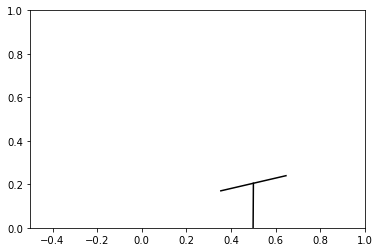

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

print(results.solver.status) 
print(results.solver.termination_condition) 

fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,1])
    ax.set_ylim([0,1])
    
    #plot body
    body_xb = m.q0[i,'x'].value - 0.5*m.lb*cos(m.q0[i,'theta_b'].value)
    body_yb = m.q0[i,'z'].value - 0.5*m.lb*sin(m.q0[i,'theta_b'].value)
    body_xf = m.q0[i,'x'].value + 0.5*m.lb*cos(m.q0[i,'theta_b'].value)
    body_yf = m.q0[i,'z'].value + 0.5*m.lb*sin(m.q0[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
    
    #plot leg 
    leg_xt = m.q0[i,'x'].value 
    leg_yt = m.q0[i,'z'].value 
    leg_xb = m.q0[i,'x'].value + m.q0[i,'r'].value*cos(m.q0[i,'theta_l'].value)
    leg_yb = m.q0[i,'z'].value - m.q0[i,'r'].value*sin(m.q0[i,'theta_l'].value)
    ax.plot([leg_xt,leg_xb],[leg_yt,leg_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

HTML(animate.to_jshtml())

In [27]:
'''from numpy import asarray
from numpy import save

data = asarray([[N for n in range (1, N+1)],
                [m.lb.value for n in range (1, N+1)],
                [m.lb.value for n in range(1, N+1)],
                [m.tau_a[n].value for n in range (1, N+1)],
                [m.F_a[n].value for n in range (1, N+1)],
                [m.q0[n,'theta_l'].value for n in range (1, N+1)],
                [m.q0[n,'r'].value for n in range (1, N+1)],
                [m.q0[n,'x'].value for n in range (1, N+1)],
                [m.q0[n,'z'].value for n in range (1, N+1)]])
save('data.npy', data)'''



"from numpy import asarray\nfrom numpy import save\n\ndata = asarray([[N for n in range (1, N+1)],\n                [m.lb.value for n in range (1, N+1)],\n                [m.lb.value for n in range(1, N+1)],\n                [m.tau_a[n].value for n in range (1, N+1)],\n                [m.F_a[n].value for n in range (1, N+1)],\n                [m.q0[n,'theta_l'].value for n in range (1, N+1)],\n                [m.q0[n,'r'].value for n in range (1, N+1)],\n                [m.q0[n,'x'].value for n in range (1, N+1)],\n                [m.q0[n,'z'].value for n in range (1, N+1)]])\nsave('data.npy', data)"